<a href="https://colab.research.google.com/github/Ahtesham519/Genrative_Deep_learning_v2_2023/blob/main/RealNVP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    regularizers,
    metrics,
    optimizers,
    callbacks,
)

import tensorflow_probability as tfp

#0. Parameters

In [2]:
COUPLING_DIN = 256
COUPLING_LAYERS = 2
INPUT_DIM = 2
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 300

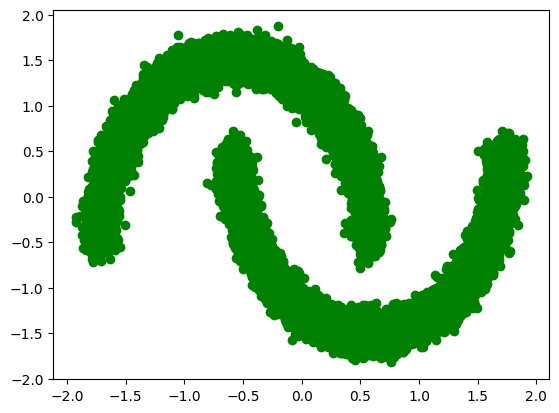

In [3]:
#Load the data
data = datasets.make_moons(30000, noise = 0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)
plt.scatter(
    normalized_data.numpy()[:, 0], normalized_data.numpy()[:, 1], c = "green"
)
plt.show()

# 2. Build the REALNVP network

In [1]:
def Coupling(input_dim , coupling_dim , reg):
  input_layer = layers.Input(shape= input_dim)

  s_layer_1 = layers.Dense(
      coupling_dim , activation = "relu" , kernel_regularizer = regularizers.l2(reg)
  )(input_layer)
  s_layer_2 = layers.Dense(
      coupling_dim , activation ="relu" , kernel_regularizer = regularizers.l2(reg)
  )(s_layer_1)
  s_layer_3 = layers.Dense(
      coupling_dim , activation = "relu", kernel_regularizer = regularizers.l2(reg)
  )(s_layer_2)
  s_layer_4 = layers.Dense(
      coupling_dim , activation = "relu" , kernel_regularizer = regularizers.l2(reg)
  )(s_layer_3)
  s_layer_5 = layers.Dense(
      input_dim , activation = "tanh" , kernel_regularizer =regularizers.l2(reg)
  )(s_layer_4)

  t_layer_1 = layers.Dense(
      coupling_dim , activation = "relu" , kernel_regularizer = regularizers.l2(reg)
  )(input_layer)
  t_layer_2 = layers.Dense(
      coupling_dim, activation = "relu" , kernel_regularizer = regularizers.l2(reg)
  )(t_layer_1)
  t_layer_3 = layers.Dense(
      coupling_dim , activation = "relu" , kernel_regularizer = regularizers.l2(reg)
  )(t_layer_2)
  t_layer_4 = layers.Dense(
      coupling_dim , activation ="relu" , kernel_regularizer = regularizers.l2(reg)
  )(t_layer_3)
  t_layer_5 = layers.Dense(
      input_dim, activation = "linear" , kernel_regularizer = regularizers.l2(reg)
  )(t_layer_4)
  return models.Model(inputs = input_layer, output= [s_layer_5, t_layer_5])

In [ ]:
class RealNVP(models.Model):
  def __init__(
      self, input_dim , coupling_layers, coupling_dim , regularization
  ):
  super(RealNVP, self).__init__()
  self.coupling_layers = coupling_layers
  self.distribution = tfp.sidtributions.MultivariateNormalDiag(
      loc = [0.0 , 0.0], scale_diag = [1.0, 1.0]
  )
  self.masks - np.array(
      [[0,1] , [1,0]] * (coupling_layers // 2), dtype = "float32"
  )
  self.loss_tracker = metrics.Mean(name = "loss")
  self.layers_list = [
      Coupling(input_dim , coupling_dim, regularization)
      for i in range(coupling_layers)
  ]

  @property
  def metrics(self):
    return [ self.loss_tracker]

  def call(self, x, training = True):
    log_det_inv = 0
    direction = 1
    if training:
      direction = -1
    for i in range(self.coupling_layers)[::direction]:
      x_masked = x * self.masks[i]
      reversed_mask = 1- self.masks[i]
      s,t = self.layers_list[i](x_masked)
      s *= reversed_mask
      s *= reversed_mask
      gate = (direction - 1)/2
      x = (
          reversed_mask
          * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
          + x_masked
      )
      log_det_inv  += gate * tf.reduce_sum(s, axis = 1)
    return x , log_det_inv

  def log_loss(self, x):
    y , logdet = self(x)
    log_likelihood = self.distribution.log_prob(y) + logdet
    return -tf.reduce_mean(log_likelihood)

  def train_step(self, data):
    with tf.GradientTape() as tape:
      loss = self.log_loss(data)
    g = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(g, self.trainable_variables))
    self.loss_tracker.update_state(loss)
    return {"loss" : self.loss_tracker.result()}

  def test_step(self, data):
    loss = self.log_loss(data)
    self.loss_tracker.update_state(loss)
    return {"loss" :self.loss_tracker.result()}

model = RealNVP(
    input_dim = INPUT_DIM,
    coupling_layers = COUPLING_LAYERS,
    coupling_dim = COUPLING_DIM,
    regularization = REGULARIZATION,
)